# Image To Image Translation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

## Loading Data

In [ ]:
!wget --header="Host: efrosgans.eecs.berkeley.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/" "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz" -c -O 'maps.tar.gz'

--2021-10-06 17:21:42--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  1002KB/s    in 1m 52s  

2021-10-06 17:23:34 (2.13 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
# unzipping dataset
!tar -xzvf "/content/maps.tar.gz" -C "/content"    

## EDA

In [ ]:
train_path = '/content/maps/train'
val_path = '/content/maps/val'

In [ ]:
train_images_path = []
val_images_path = []
# Append base path to image name and making a list of it
for img_path in os.listdir(train_path):
    train_images_path.append(os.path.join(train_path, img_path))

for img_path in os.listdir(val_path):
    val_images_path.append(os.path.join(val_path, img_path))

### Splitting dataset

In [ ]:
# splitting val data in val and test data with test size of 0.05
val_images_path, test_images_path = train_test_split(val_images_path, test_size = 0.05, random_state =42, shuffle = True, )

In [ ]:
print('Count of images in train data : ', len(train_images_path))
print('Count of images in val data : ', len(val_images_path))
print('Count of images in test data: ',len(test_images_path))

Count of images in train data :  1096
Count of images in val data :  1043
Count of images in test data:  55


> Train data contains 1096 images while val data contain 988 images. Let's look into train data.

Let's display few images to see how data looks like

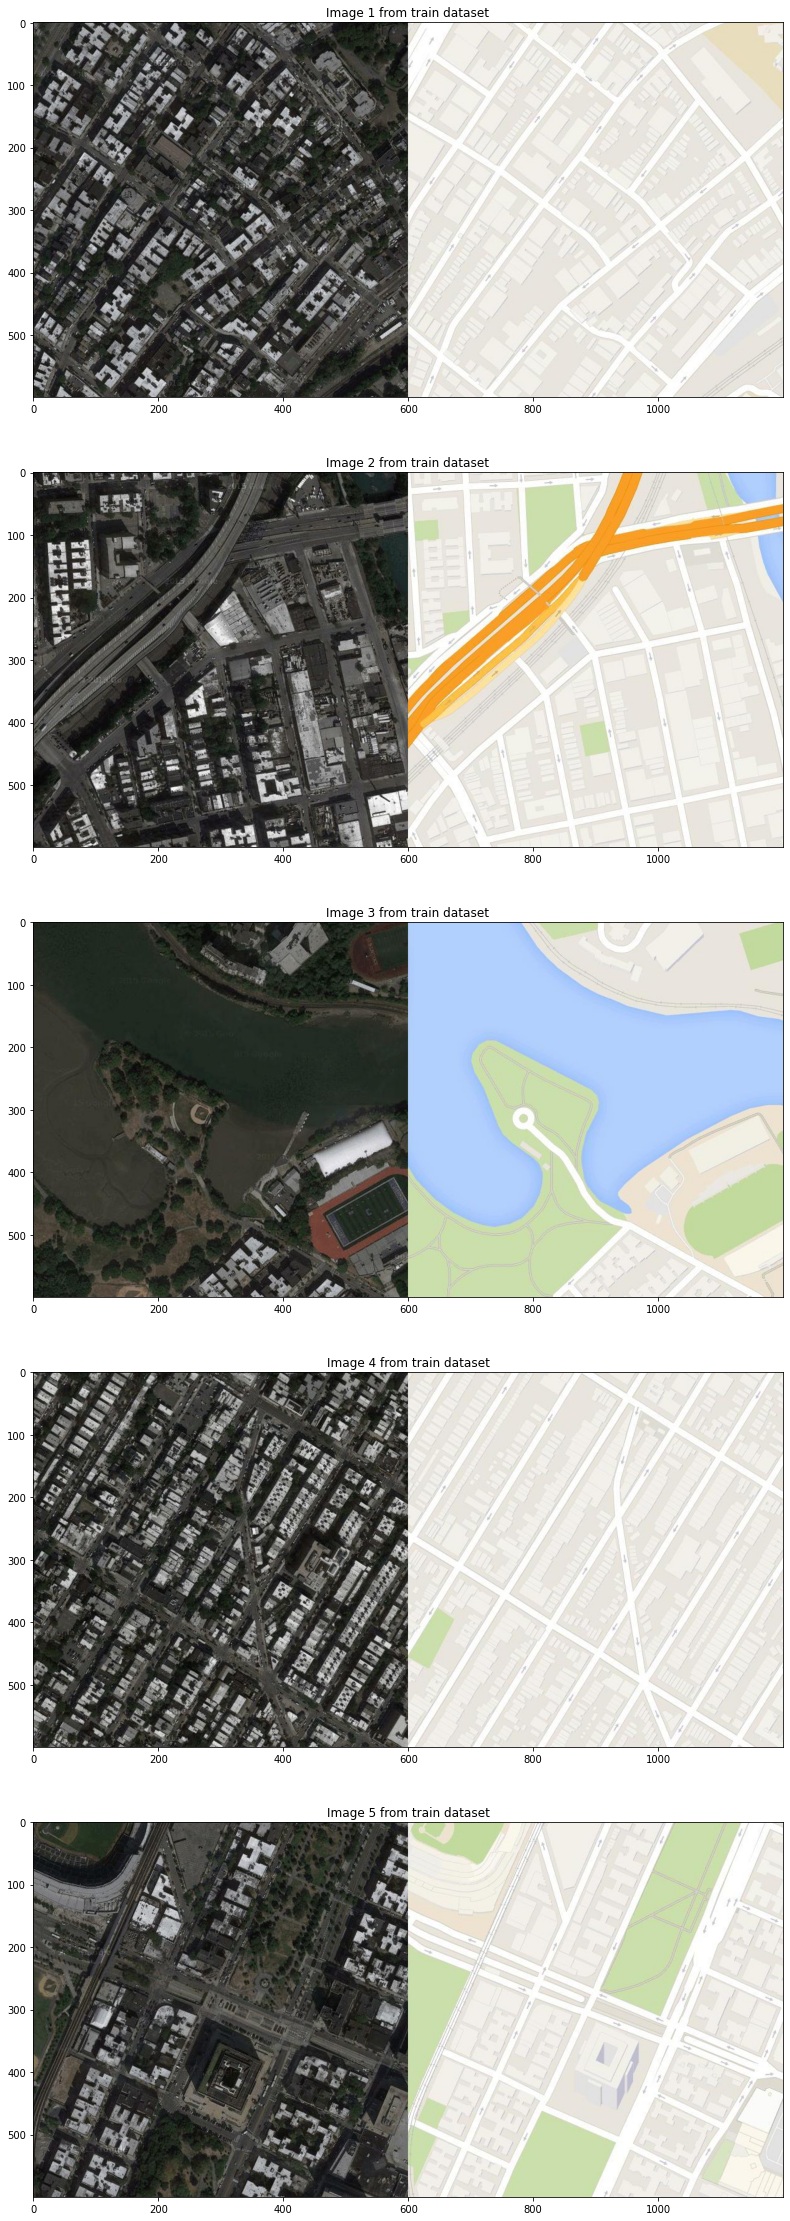

In [ ]:
#displaying sample images
plt.figure(figsize=(20,40))
for i, img_path in enumerate(train_images_path[25:30]):
    plt.subplot(5,1,i+1)
    img = plt.imread(img_path) # reading image path
    plt.title('Image {} from train dataset'.format(i+1))
    plt.imshow(img) #plotting image

> As you can see from displayed images above, an image contain 2 fragments: satellite and aerial map.
For our purpose, satellite fragment is input and aerial map is output.
So, we'll be splitting our given image into two.

In [ ]:
img = Image.open(train_images_path[0])

In [ ]:
print('Size of image: ',img.size)

Size of image:  (1200, 600)


> Each image is of size 1200x600 (width x height) which consits of both satellite and map image as well. So, after splitting image size will be 600x600


Let's split the image into sat. and map part.

### Splitting images

In image splitting, we'll also be resizing images to 256x256 from the original size of 600x600.

In [ ]:
#https://keras.io/api/preprocessing/image/#loadimg-function
#https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

# splitting the raw images into sattelite and map images
def split_images(images):
    '''This function take list of image paths as input and return 2 arrays: source images and target images'''
    source_images = []
    target_images = []
    for image_path in tqdm(images):
        # loading the image using the image path
        img = load_img(path = image_path, target_size= (256,512))

        #converting img to array of pixel values
        pixels = img_to_array(img)

        #splitting the image into 2.
        sat_img, map_img = pixels[:,:256], pixels[:,256:]

        source_images.append(sat_img)
        target_images.append(map_img)

    return np.asarray(source_images), np.asarray(target_images)

In [ ]:
train_sat_images, train_map_images = split_images(train_images_path)

100%|██████████| 1096/1096 [00:14<00:00, 75.59it/s]


In [ ]:
val_sat_images, val_map_images = split_images(val_images_path)

100%|██████████| 1043/1043 [00:16<00:00, 61.87it/s]


In [ ]:
test_sat_images, test_map_images = split_images(test_images_path)

100%|██████████| 55/55 [00:01<00:00, 51.75it/s]


In [ ]:
train_sat_images.shape

(1096, 256, 256, 3)

In [ ]:
train_map_images.shape

(1096, 256, 256, 3)

In [ ]:
val_sat_images.shape

(1043, 256, 256, 3)

In [ ]:
val_map_images.shape

(1043, 256, 256, 3)

In [ ]:
test_sat_images.shape

(55, 256, 256, 3)

In [ ]:
test_map_images.shape

(55, 256, 256, 3)

### Data distribution for Satellite images 

In [ ]:
def plot_dist(data,label):
    '''This function takes in image data (numpy array) as input and plots distribution of pixel values'''
    color = ('b','g','r')
    plt.figure(figsize=(10,10))
    for i,col in enumerate(color):
        histr = cv2.calcHist(data,[i],None,[256],[0,256])
        plt.plot(histr,color = col, label = col)
        plt.xlim([0,256])
    plt.title('Data distribution of {} Images'.format(label))
    plt.xlabel('Pixels')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

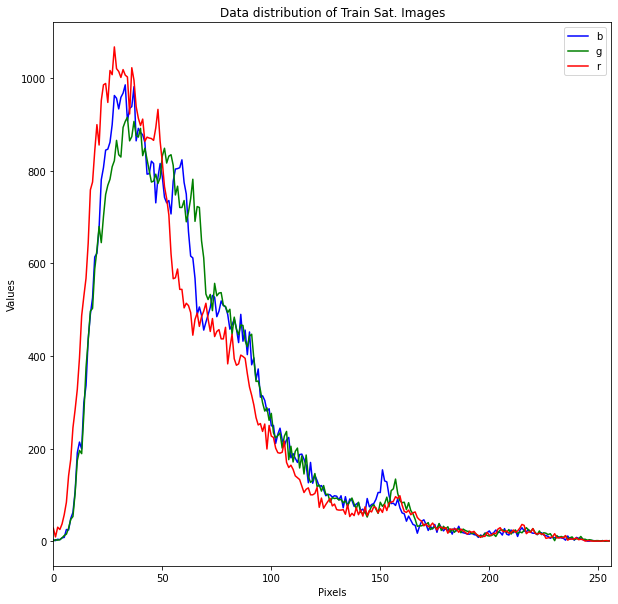

In [ ]:
#https://docs.opencv.org/3.1.0/d1/db7/tutorial_py_histogram_begins.html
#https://datascience.stackexchange.com/questions/45711/how-can-i-plot-display-a-dataset-or-an-image-distribution

plot_dist(train_sat_images,'Train Sat.')

> Observation:
- most of pixels for satellite are concentrated in region 40 to 50.
- Graph is skewed to right.

Let's compare the train distribution to validation

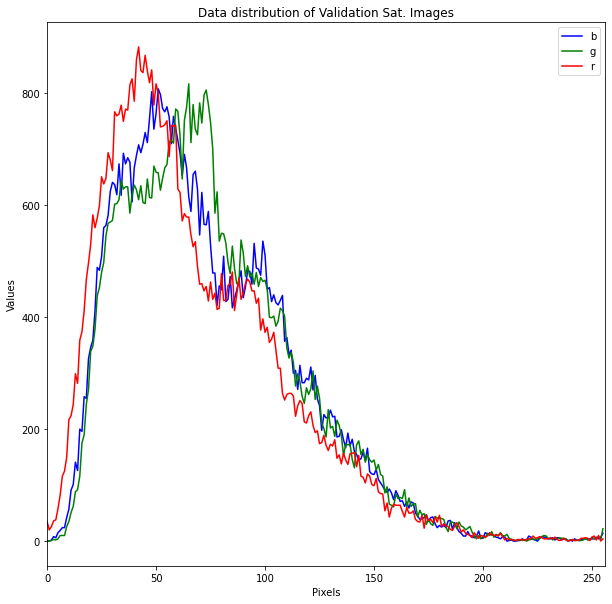

In [ ]:
plot_dist(val_sat_images, 'Validation Sat.')

> Observation:
- Both the distributions are similar in nature.
- Validation dist. is also skewed to right.

## Scale images

Before we start with modeling, we'll be scaling our images in range [-1,1] from [0,255]

In [ ]:
train_sat_images.dtype

dtype('float32')

In [ ]:
def scale_images(sat_images, map_images):
    '''This function takes in sattelite and map images and return the images scales in range [-1,1]'''
    sat_images = (sat_images - 127.5)/127.5
    map_images = (map_images - 127.5)/127.5
    return sat_images, map_images

In [ ]:
train_sat_images, train_map_images =  scale_images(train_sat_images, train_map_images)
val_sat_images, val_map_images = scale_images(val_sat_images, val_map_images)
test_sat_images, test_map_images = scale_images(test_sat_images, test_map_images)

## Saving the image arrays

In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html#numpy.savez_compressed
np.savez_compressed('image_data', 
                    train_sat_images = train_sat_images, 
                    train_map_images = train_map_images, 
                    val_sat_images = val_sat_images, 
                    val_map_images = val_map_images, 
                    test_sat_images = test_sat_images, 
                    test_map_images = test_map_images)